In [21]:
from dependencies import *
from model import *
from defaults import *
from background import *

### Create hypothetical LIP parameters

In [ ]:
# LIP emplacement characteristics
B0 = 3e2 # LIP height [m]
erup_freq = 1e4/1e6 # eruption frequency [Myr]
emp_dur = 1
degass = 0.85 # [examol C]

# Rock weathering characteristics
P0 = 330 # optimal saprolite production [m/Myr]
E_P = 100/330 # optimal saprolite production [m/Myr]
c = 0 # erosion dependence on slope []

# Feedback sensitivities
n = 0.5 # global weathering feedback strength
n_p = 0.5 # LIP weathering feedback strength
n_e = 0.5 # LIP erosion feedback strength

# Background climate
T0 = 0 # we will only consider normalized cooling
b = 5.35 # CO2 radiative forcing coefficient

# LIP areas
A0_small = 1e12 # m2
A0_large = 10e12 # m2

### Helper functions to run model over geologic time

In [23]:
# runs model with the default parameters
def min_T_defaults(A0,N0,V,T0=0):
    t,N = run_model(dt=dt,t_max=t_max, # model setup
                    emp_dur=emp_dur,A0=A0, # LIP emplacement characteristics
                    B0=B0,erup_freq=erup_freq, # LIP emplacement characteristics
                    degass=degass, # LIP degassing characteristics
                    P0=P0,E_P=E_P,d=d,c=c,Xm=Xm, # Rock weathering characteristics
                    N0=N0,V=V, # Background climate
                    n=n,n_p=n_p,n_e=n_e) # Feedback sensitivities
    T = T0+x(N,N0,b,a)
    min_T = np.min(T)
    return min_T

# iterate over geologic time with CO2 confidence intervals
def min_T_geologic(A0,t_Earth,t_V,t_N0,filename=None):
    # for each Earth history time step
    results_arr = []
    for i in range(len(t_Earth)):
        V = t_V[i]
        results_i = []
        # for CO2 lower 95% confidence interval, median, upper 95% confidence interval
        for N0 in t_N0[:,i]:
            results_i.append(min_T_defaults(A0=A0,N0=N0,V=V))
        results_arr.append(results_i)
    results_arr = np.array(results_arr).T
    if filename:
        np.save(f"data/{filename}.npy",results_arr)
    return results_arr

### Simulate through all of Earth's history

In [27]:
## Read in Krissansen-Totton et al. 2018 data

all_output = np.load('data/kt_data.npy')
t_Earth = all_output[4,:,0]/1e9

# pCO2
confidence_CO2 = st.scoreatpercentile(all_output[6,:,:],
                                      [2.5,50,97.5], # lower 95% confidence interval, median, and upper 95% confidence interval
                                      interpolation_method='fraction',axis=1)
t_CO2 = confidence_CO2*1e6 # convert to ppm
N_pi,ppm_pi = 2.83,288 # preindustrial examol C, ppm CO2
t_N0 = N_pi*np.sqrt(t_CO2/ppm_pi)

# volcanic degassing
median_V = st.scoreatpercentile(all_output[24,:,:],[50],
                           interpolation_method='fraction',axis=1)
t_V = median_V[0]/1e12 # convert Tmol/yr to examol/Myr

# save for interpolation into Phanerozoic
t_KT = t_Earth.copy()
t_V_KT = t_V.copy()

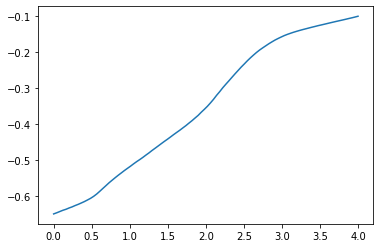

In [30]:
# small LIP
KT_small = min_T_geologic(A0=A0_small,filename="geologic_KT_small",
                            t_Earth=t_Earth,t_V=t_V,t_N0=t_N0)

plt.plot(t_Earth,KT_small[1])

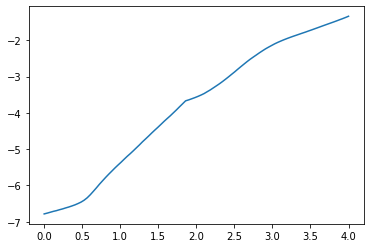

In [31]:
# large LIP
KT_large = min_T_geologic(A0=A0_large,filename="geologic_KT_large",
                            t_Earth=t_Earth,t_V=t_V,t_N0=t_N0)
plt.plot(t_Earth,KT_large[1])

### Simulate through Phanerozoic time

In [32]:
## Read in Foster et al. 2017 data

df = pd.read_excel('data/foster-2017.xlsx',skiprows=1)
t_Earth = np.array(df['Age (Ma)'])
df[df < 0] = 1 # clip negative values

confidence_CO2_df = df[['lw95%','pCO2 probability maximum','up95%']]
t_CO2 = confidence_CO2_df.to_numpy().T
N_pi,ppm_pi = 2.83,288 # preindustrial examol C, ppm CO2
t_N0 = N_pi*np.sqrt(t_CO2/ppm_pi)

# interpolate global degassing rates onto Phanerozoic time array
t_V = np.array([interp(i,t_KT*1e3,t_V_KT) for i in t_Earth])

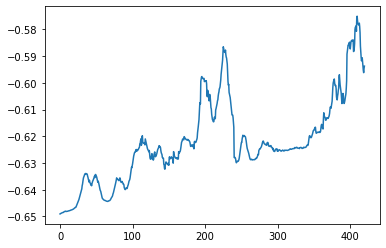

In [33]:
# small LIP
Foster_small = min_T_geologic(A0=A0_small,filename="geologic_Foster_small",
                            t_Earth=t_Earth,t_V=t_V,t_N0=t_N0)
plt.plot(t_Earth,Foster_small[1])

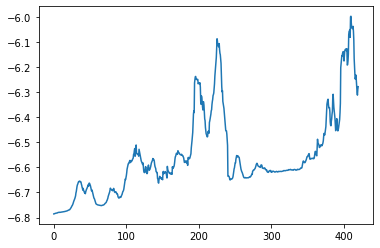

In [34]:
# large LIP
Foster_large = min_T_geologic(A0=A0_large,filename="geologic_Foster_large",
                            t_Earth=t_Earth,t_V=t_V,t_N0=t_N0)
plt.plot(t_Earth,Foster_large[1])